Install and import libraries

In [1]:
!pip install accelerate
!pip install flash_attn einops timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash_attn


In [2]:
!pip install timm flash_attn

In [3]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM

In [4]:
model_id = 'microsoft/Florence-2-large'
# model_id = 'microsoft/Florence-2-large'


model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
def florence2(task_prompt, images, text_input=None):
  """
  Calling the Microsoft Florence-2 Model
  """
  if text_input is None:
    prompt = task_prompt
  else:
    prompt = task_prompt + text_input

  inputs = processor(text=prompt, images=images, return_tensors="pt")

  generated_ids = model.generate(
                  input_ids = inputs["input_ids"],
                  pixel_values = inputs["pixel_values"],
                  max_new_tokens = 1024,
                  early_stopping = False,
                  do_sample = False,
                  num_beams = 3,
                  )
  generated_text = processor.batch_decode(generated_ids,
                                          skip_special_tokens=False)[0]

  parsed_answer = processor.post_process_generation(
      generated_text,
      task=task_prompt,
      image_size=(image.width, image.height)
      )
  return parsed_answer




Object Detection

In [6]:
!unzip data.zip

Archive:  data.zip
   creating: data/
 extracting: data/animal1.jpg        
  inflating: data/b1.jpg             
  inflating: data/b2.jpg             
  inflating: data/r2.jpg             
  inflating: data/r3.jpg             
  inflating: data/y1.jpg             
  inflating: data/y2.jpg             
  inflating: data/y3.jpg             


In [7]:
image = Image.open('/content/data/animal1.jpg')

task_prompt3 = '<OD>'
od_results = florence2(task_prompt3, image)
od_results['<OD>']

{'bboxes': [[115.80000305175781, 185.43150329589844, 663.0, 718.0964965820312],
  [826.2000122070312,
   360.04949951171875,
   952.2000122070312,
   680.4495239257812]],
 'labels': ['elephant', 'person']}

In [8]:
def plot_bbox(image,data):
  fig ,ax = plt.subplots()

  #Display the image
  ax.imshow(image)

  #Plot each bounding box
  for bbox, label in zip(data['bboxes'], data['labels']):
    # Unpack the bounding box coordinates
    x1,y1,x2,y2 = bbox
    #Create a rectangle patch
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1, linewidth=1,edgecolor='r', facecolor='none')
    #Add the rectangle to the Axes
    ax.add_patch(rect)
    #Annotate the label
    plt.text(x1,y1,label, color='white',fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

  #Remove axis ticks and labels
  ax.axis('off')

  #show the plot
  plt.show()

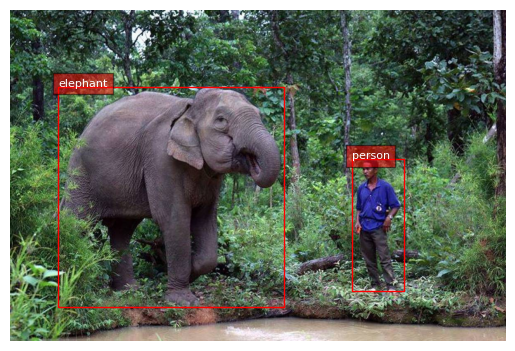

In [9]:
plot_bbox(image,od_results['<OD>'])

Guided Object Detection

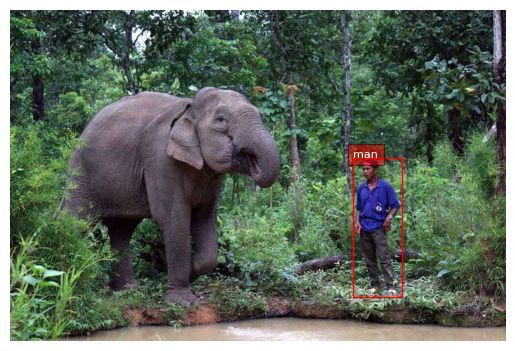

In [10]:
task_prompt4 = "<CAPTION_TO_PHRASE_GROUNDING>"

result = florence2(task_prompt4, image,text_input="man")

plot_bbox(image, result['<CAPTION_TO_PHRASE_GROUNDING>'])

Auto Data Labeling

In [14]:
def florence2(task_prompt, images, text_input=None):
  """
  Calling the Microsoft Florence-2 Model
  """
  results = []

  for image in images:
    if text_input is None:
      prompt = task_prompt
    else:
      prompt = task_prompt + text_input

    inputs = processor(text=prompt,images=images, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    results.append(parsed_answer)

  return results


In [15]:
from PIL import Image
import os

def process_images(folder_path):
    # Get all image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]

        # Load image using PIL
        try:
            image = Image.open(image_path)
        except IOError:
            print(f'Failed to open image: {image_path}')
            continue

        # Define task_prompt3 (if it's constant for all images)
        task_prompt3 = '<OD>'

        # Call your function to get results
        od_results_list = florence2(task_prompt3, [image])

        # Iterate over each result in the list
        for idx, od_results in enumerate(od_results_list):
            # Save results to a text file with the same name as the image
            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_{idx}.txt')

            with open(output_file_path, 'w') as f:
                # Write the results to the text file
                for key, value in od_results['<OD>'].items():
                    f.write(f"{key}: {value}\n")

            print(f'Results for {image_name} (index {idx}) saved to {output_file_path}')

In [16]:
folder_path = '/content/data'
process_images(folder_path)

Results for b2.jpg (index 0) saved to /content/data/b2_0.txt
Results for r2.jpg (index 0) saved to /content/data/r2_0.txt
Results for y2.jpg (index 0) saved to /content/data/y2_0.txt
Results for animal1.jpg (index 0) saved to /content/data/animal1_0.txt
Results for b1.jpg (index 0) saved to /content/data/b1_0.txt
Results for y3.jpg (index 0) saved to /content/data/y3_0.txt
Results for y1.jpg (index 0) saved to /content/data/y1_0.txt
Results for r3.jpg (index 0) saved to /content/data/r3_0.txt


Convert to yolo format

In [17]:
import os
import json

def convert_to_yolo_format(bboxes, labels, image_width, image_height):
    yolo_annotations = []

    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox

        # Calculate bounding box center and dimensions
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        box_width = (xmax - xmin) / image_width
        box_height = (ymax - ymin) / image_height

        # Find the class index (you may need to adjust this based on your class mapping)
        class_index = get_class_index(label)

        # Append annotation in YOLO format
        yolo_annotations.append(f"{class_index} {x_center} {y_center} {box_width} {box_height}")

    return yolo_annotations

def get_class_index(label):
    # Define your class mapping here
    class_mapping = {
        'elephant': 0,
        'person': 1,
        'rose':2
        # Add more classes as needed
    }
    return class_mapping.get(label, -1)  # Return -1 if label not found

def process_images(folder_path):
    # Get all image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]

        # Load image using PIL
        try:
            image = Image.open(image_path)
            image_width, image_height = image.size
        except IOError:
            print(f'Failed to open image: {image_path}')
            continue

        # Call your function to get annotations
        od_results_list = florence2('<OD>', [image])

        # Iterate over each result in the list
        for idx, od_results in enumerate(od_results_list):
            bboxes = od_results['<OD>']['bboxes']
            labels = od_results['<OD>']['labels']

            # Convert annotations to YOLO format
            yolo_annotations = convert_to_yolo_format(bboxes, labels, image_width, image_height)

            # Save YOLO annotations to a text file
            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_{idx}.txt')

            with open(output_file_path, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(annotation + '\n')

            print(f'Annotations for {image_name} (index {idx}) saved to {output_file_path}')

In [18]:
folder_path = '/content/data'
process_images(folder_path)

Annotations for b2.jpg (index 0) saved to /content/data/b2_0.txt
Annotations for r2.jpg (index 0) saved to /content/data/r2_0.txt
Annotations for y2.jpg (index 0) saved to /content/data/y2_0.txt
Annotations for animal1.jpg (index 0) saved to /content/data/animal1_0.txt
Annotations for b1.jpg (index 0) saved to /content/data/b1_0.txt
Annotations for y3.jpg (index 0) saved to /content/data/y3_0.txt
Annotations for y1.jpg (index 0) saved to /content/data/y1_0.txt
Annotations for r3.jpg (index 0) saved to /content/data/r3_0.txt
